## Analisi distribuzione classi della cartella Spettrogrammi per riduzione della dimensionalità dei dati

In [5]:
import numpy as np
import utils 

In [6]:
df_pathsTarget, df_namesTarget = utils.create_dataframe_from_files('Spettrogrammi/Target')
df_pathsNonTarget, df_namesNonTarget = utils.create_dataframe_from_files('Spettrogrammi/Non-Target')

import os

# Carica il DataFrame da df_paths.csv
# df_paths = pd.read_csv('Dataset/df_paths.csv', header=None, names=['path'])

# Crea una copia del DataFrame originale
df_pathsTargetCopy = df_pathsTarget.copy()
df_pathsNonTargetCopy = df_pathsNonTarget.copy()

# Estrai la classe e il target dai percorsi dei file
df_pathsTargetCopy['class'] = df_pathsTargetCopy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(path)))
df_pathsTargetCopy['target'] = df_pathsTargetCopy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(os.path.dirname(path))))

df_pathsNonTargetCopy['class'] = df_pathsNonTargetCopy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(path)))
df_pathsNonTargetCopy['target'] = df_pathsNonTargetCopy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(os.path.dirname(path))))

# Target

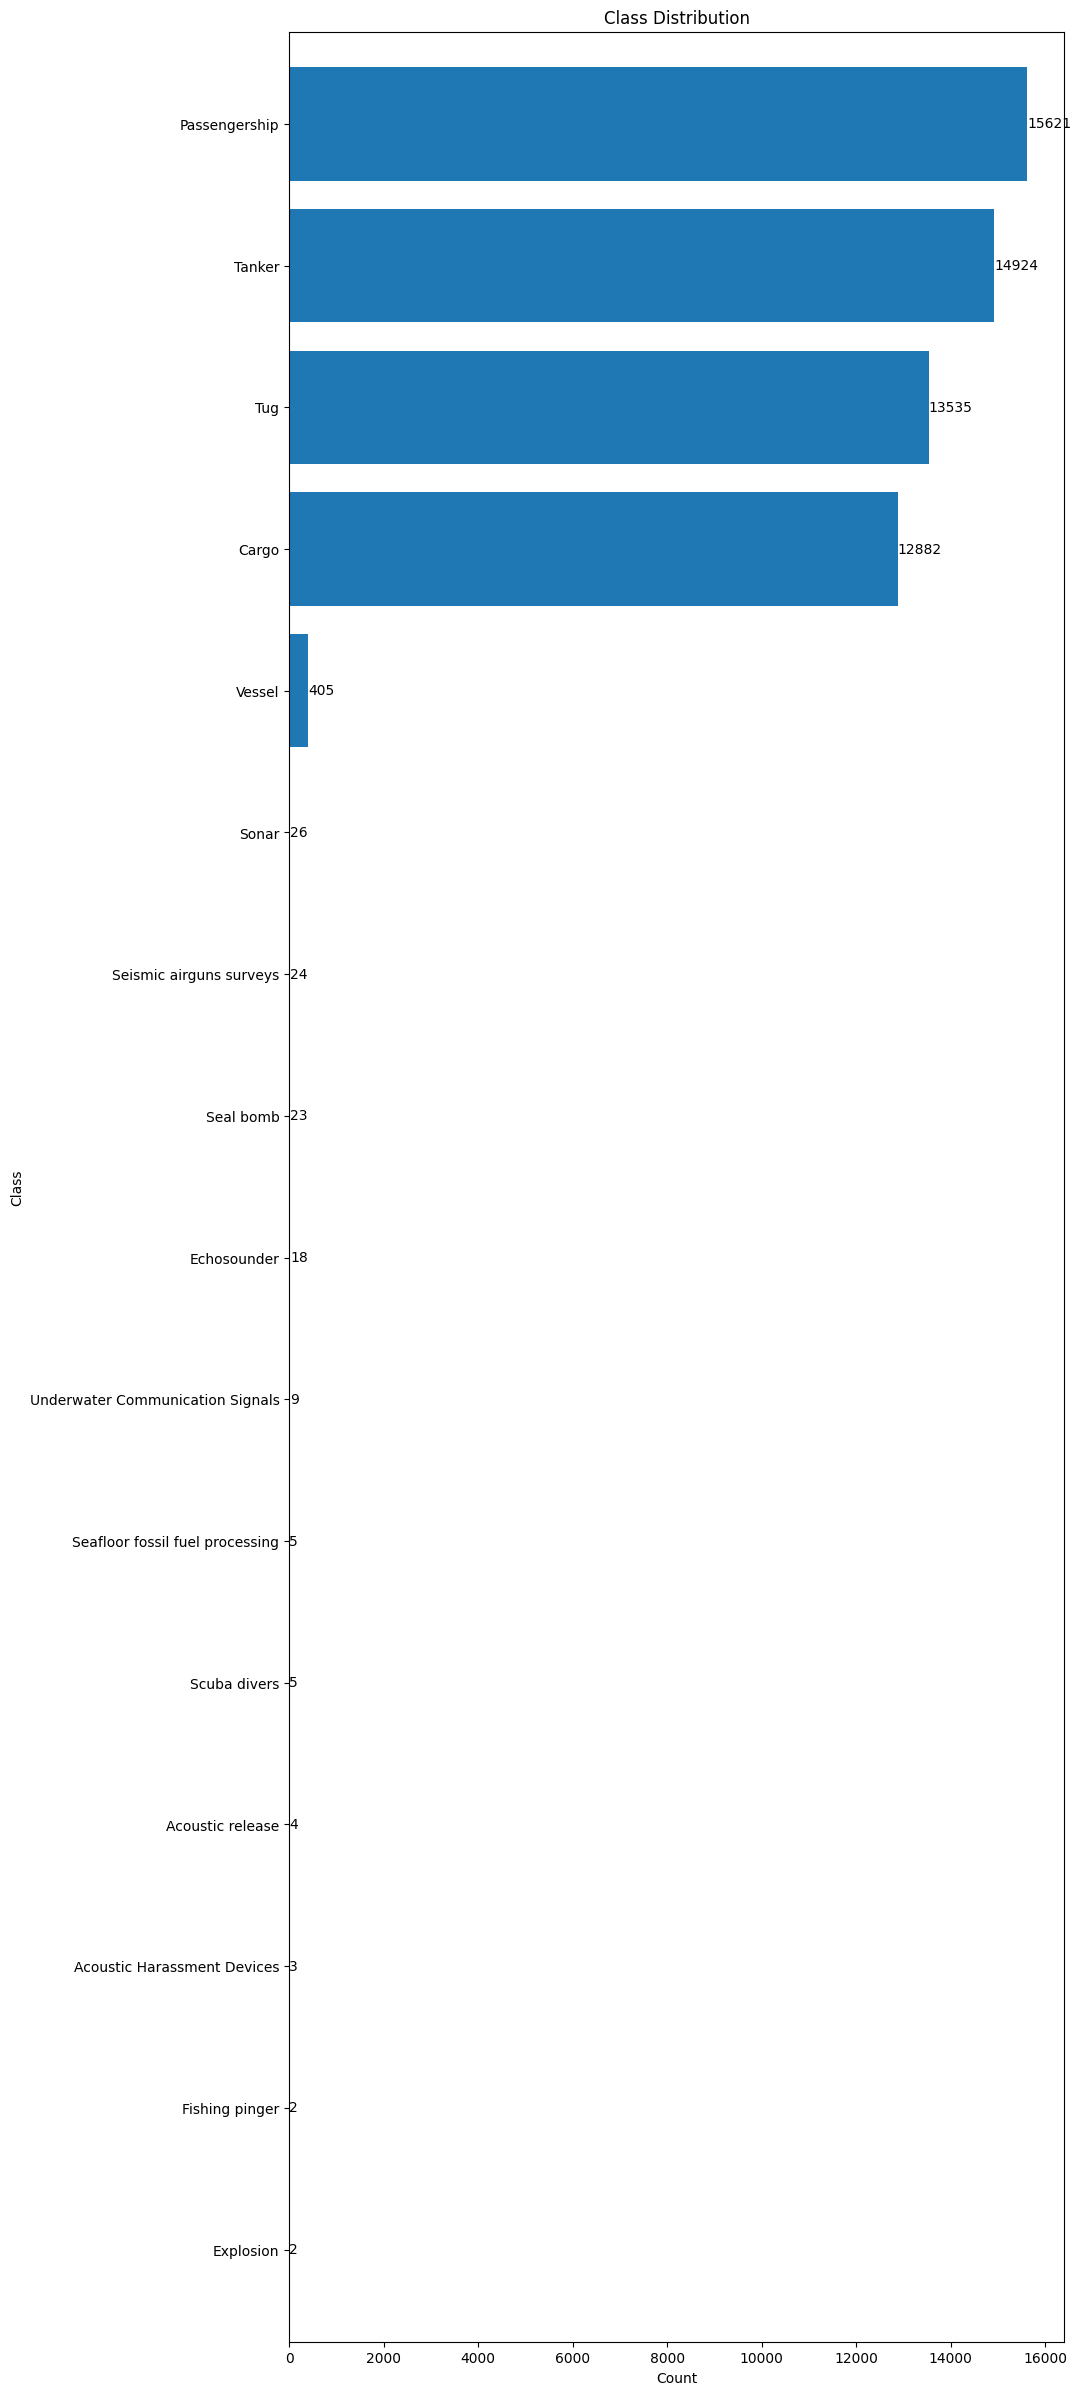

In [7]:
utils.plot_class_distribution_horizontal(df_pathsTargetCopy, 'class')

# Non Target

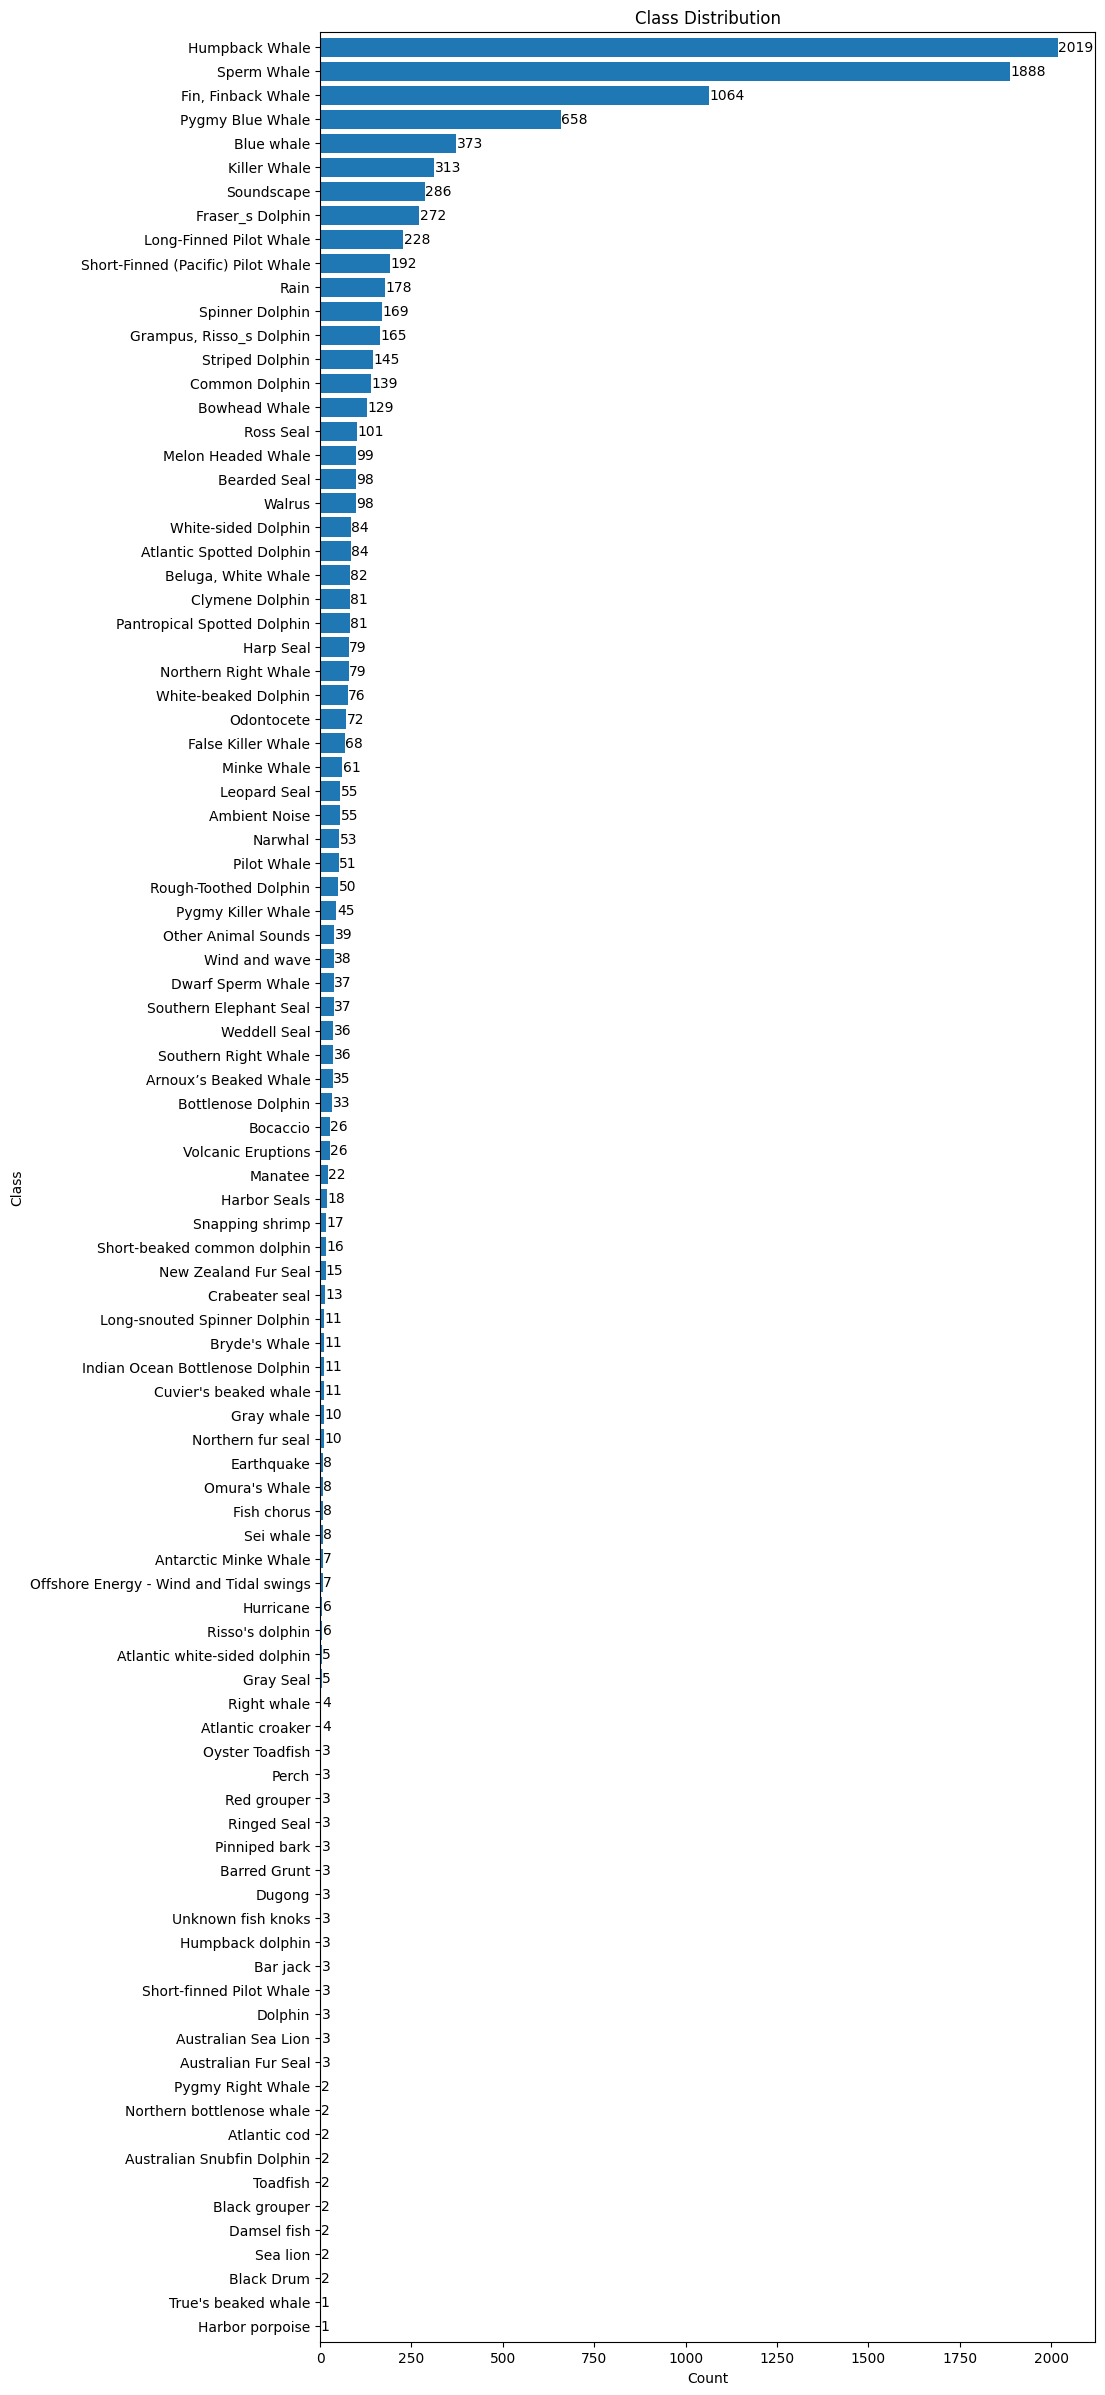

In [8]:
utils.plot_class_distribution_horizontal(df_pathsNonTargetCopy, 'class')


In [9]:
import pandas as pd
import os

def filter_csv_by_file_count(csv_path, k, output_csv_path):
    # Leggi il CSV in un DataFrame
    df = pd.read_csv(csv_path, header=None, names=['FilePath'])

    # Crea un nuovo DataFrame che raggruppa i percorsi dei file per sottocartella
    df['Subfolder'] = df['FilePath'].apply(lambda path: os.path.dirname(path))
    grouped_df = df.groupby('Subfolder').size().reset_index(name='Count')

    # Filtra il DataFrame raggruppato per mantenere solo le sottocartelle con almeno k file
    filtered_grouped_df = grouped_df[grouped_df['Count'] >= k]

    # Unisci il DataFrame originale con il DataFrame filtrato
    filtered_df = pd.merge(df, filtered_grouped_df, how='inner', on='Subfolder')

    # Rimuovi la colonna 'Count' e 'Subfolder'
    filtered_df = filtered_df.drop(columns=['Count', 'Subfolder'])

    # Salva il DataFrame risultante in un nuovo CSV
    filtered_df.to_csv(output_csv_path, index=False, header=False)

# Usa la funzione per filtrare il CSV
filter_csv_by_file_count('Spettrogrammi/Target/df_paths.csv', 5, 'Spettrogrammi/Target/df_paths_filtered.csv')

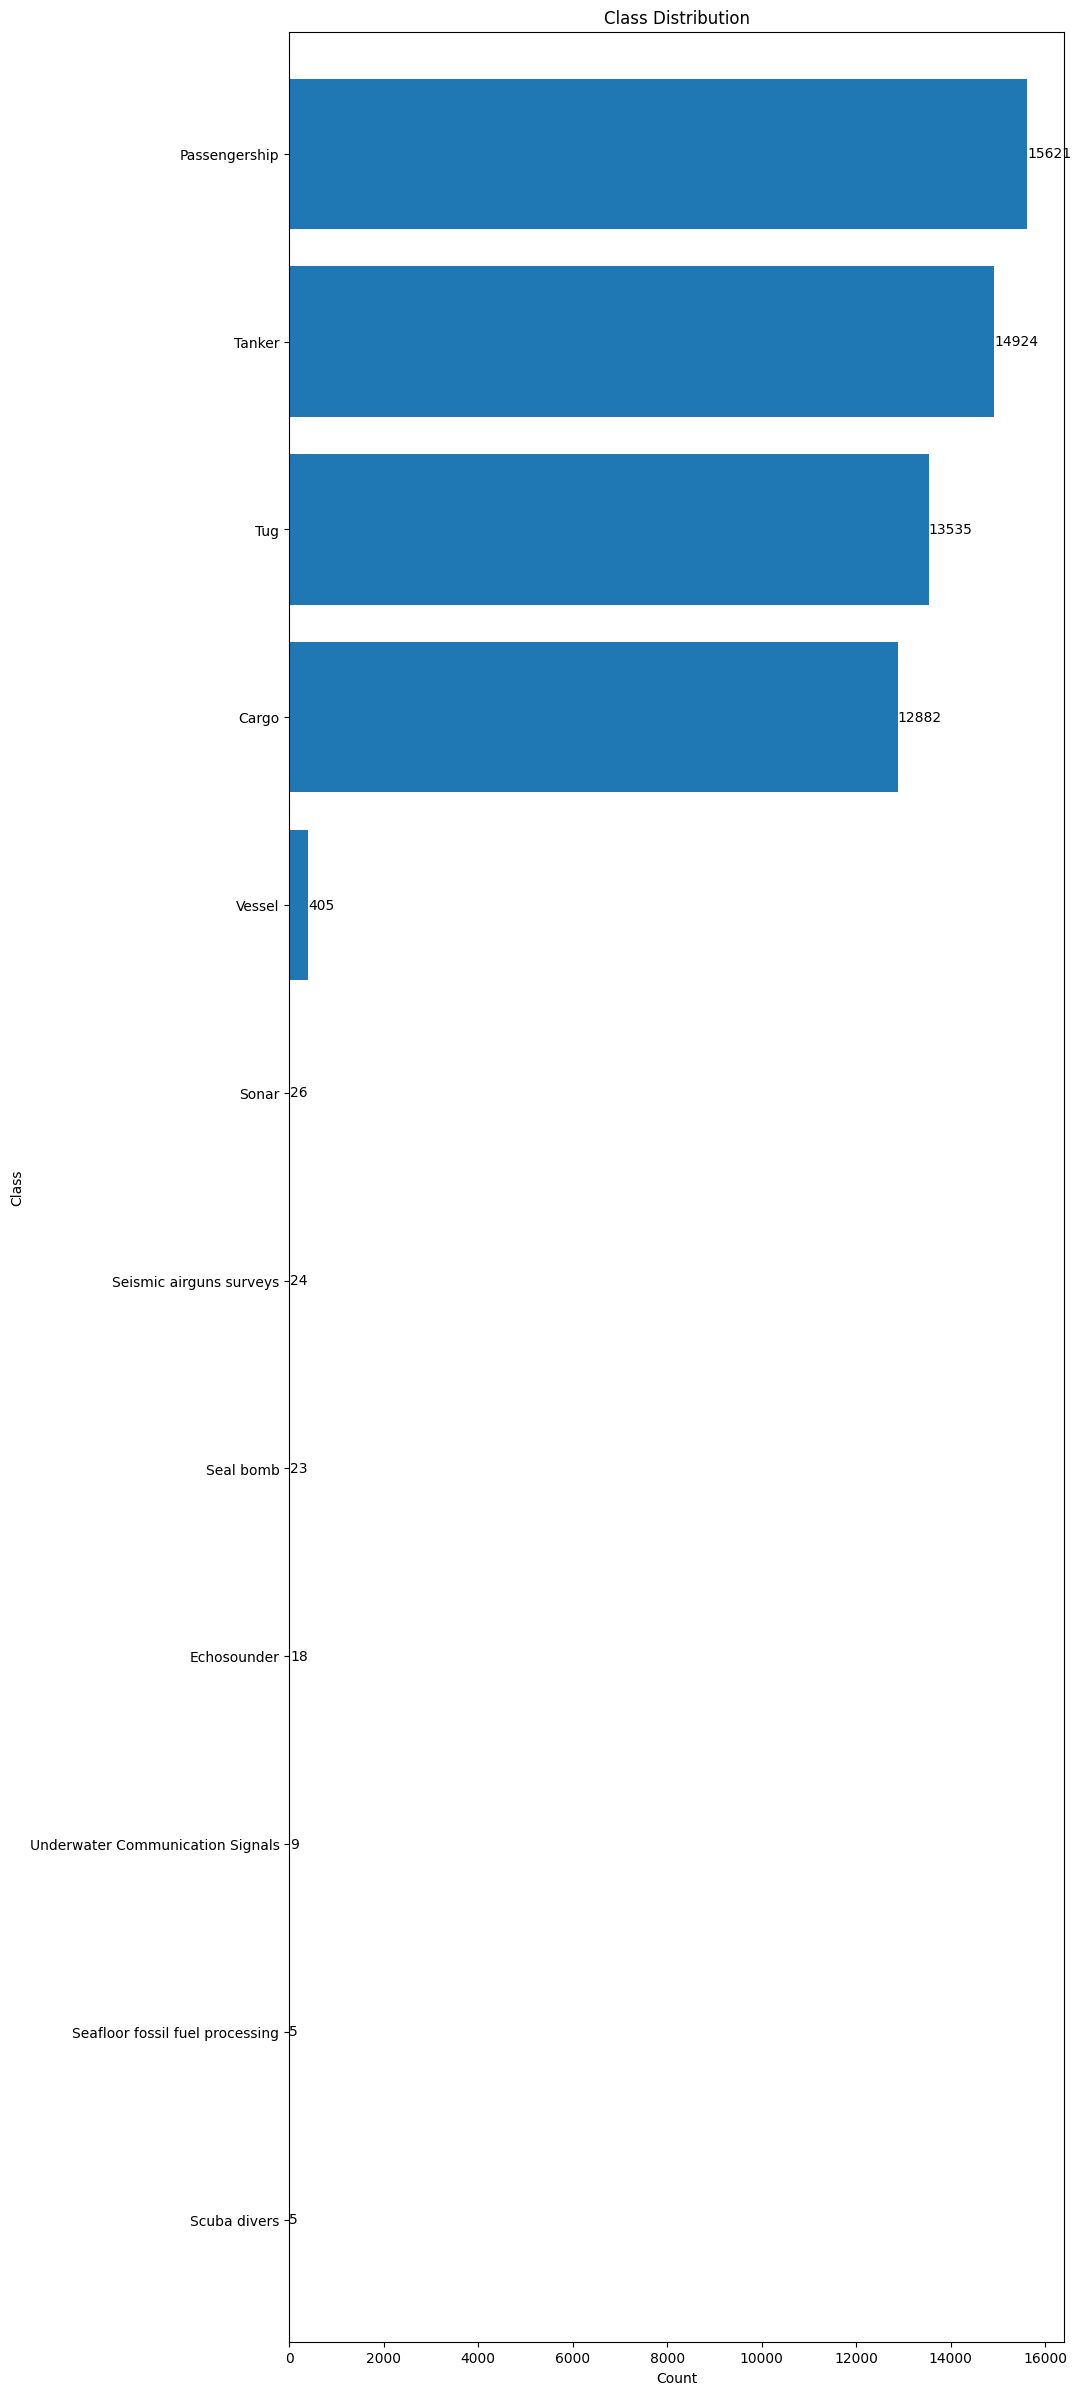

In [11]:
df_filtered = pd.read_csv('Spettrogrammi/Target/df_paths_filtered.csv', header=None, names=['FilePath'])
df_filtered_copy = df_filtered.copy()

df_filtered_copy['class'] = df_filtered_copy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(path)))
df_filtered_copy['target'] = df_filtered_copy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(os.path.dirname(path))))
utils.plot_class_distribution_horizontal(df_filtered_copy, 'class')


In [12]:
filter_csv_by_file_count('Spettrogrammi/Non-Target/df_paths.csv', 5, 'Spettrogrammi/Non-Target/df_paths_filtered.csv')


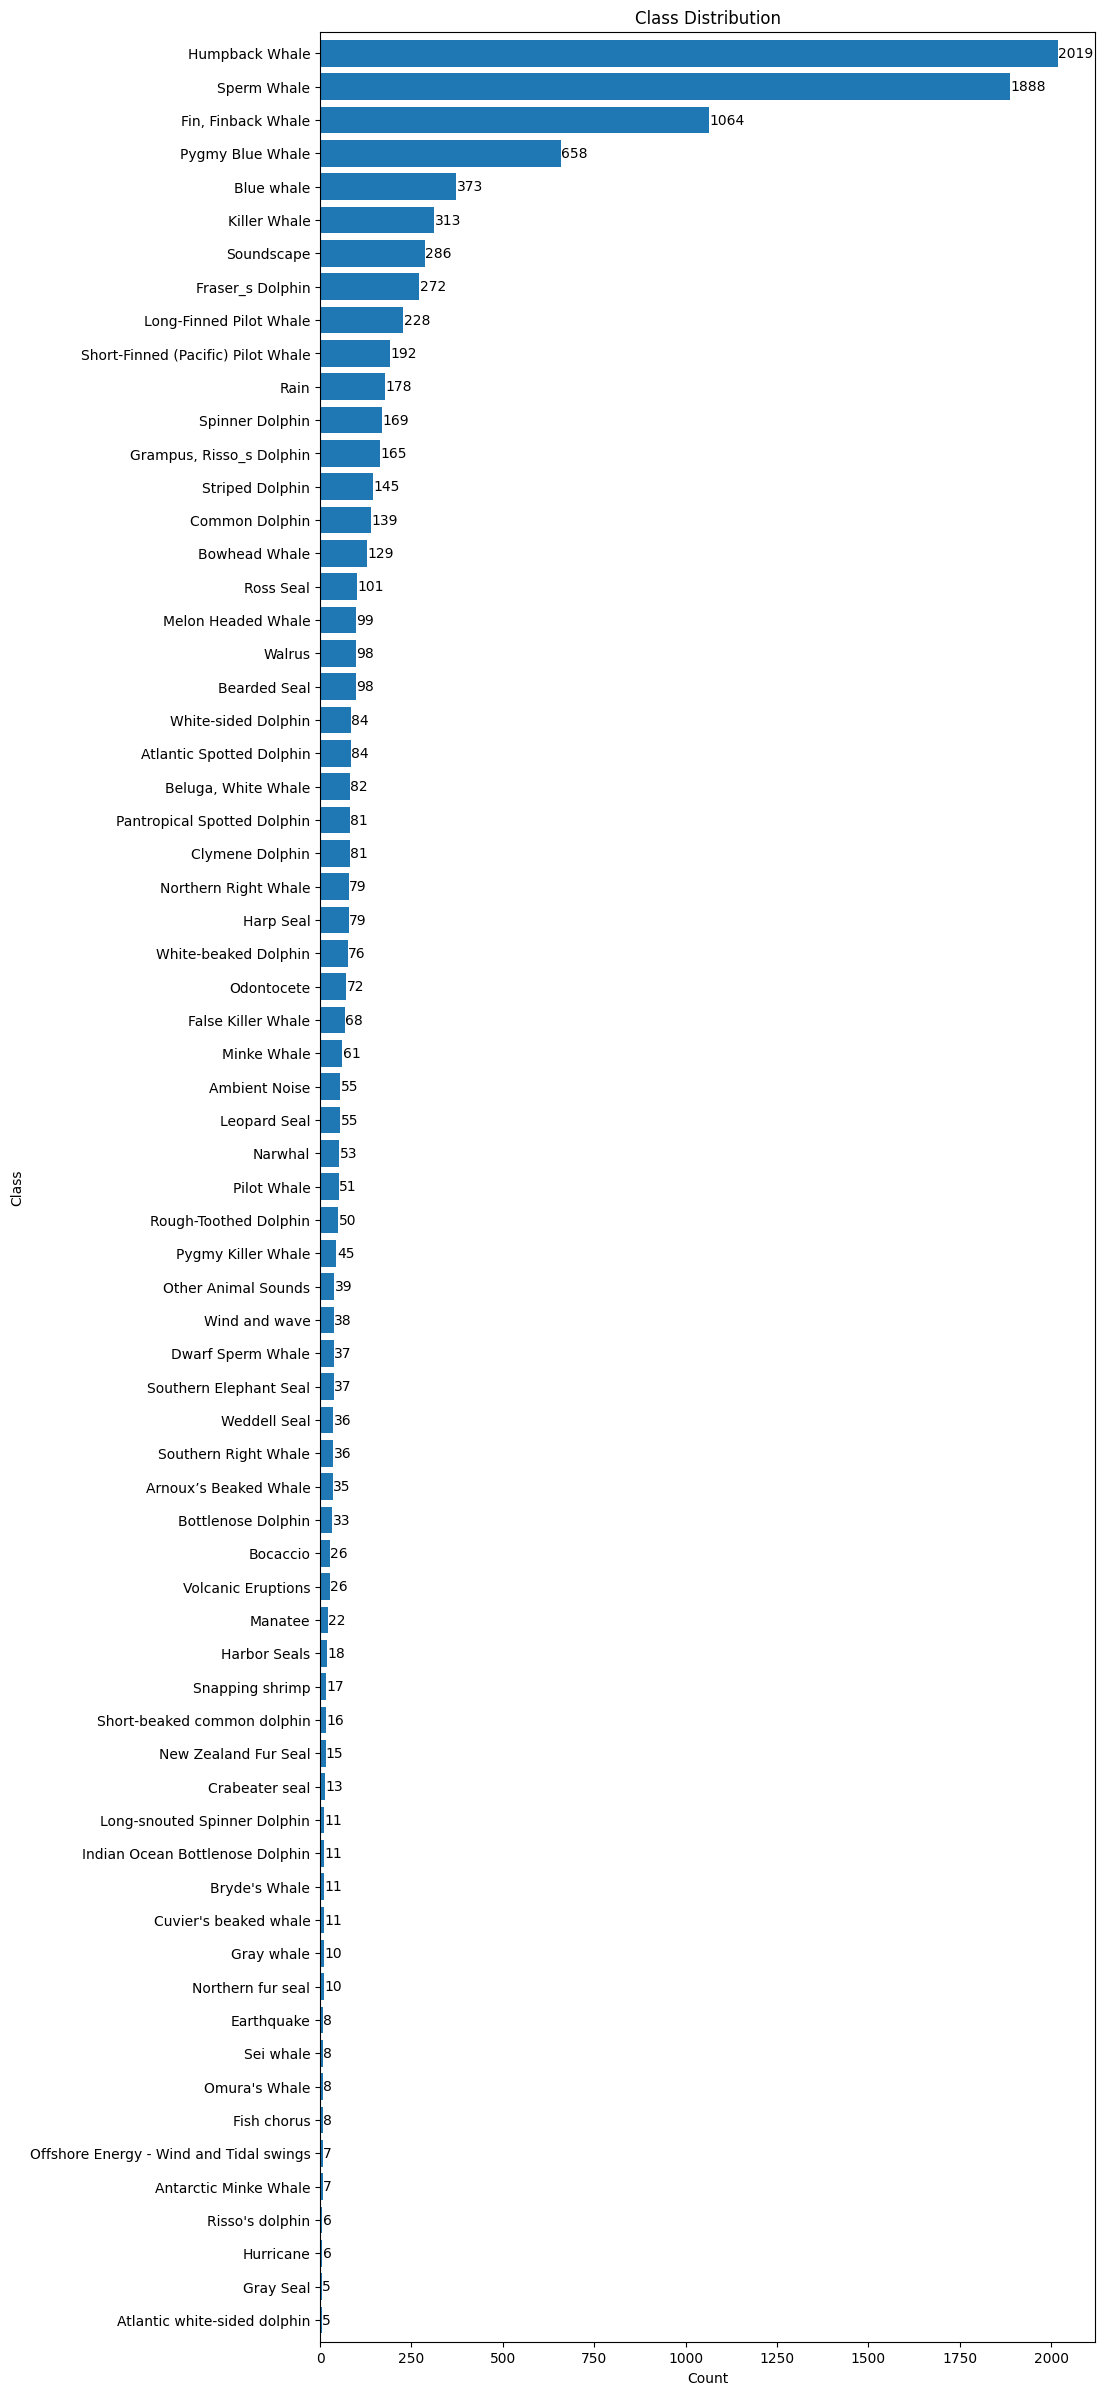

In [13]:
df_filtered = pd.read_csv('Spettrogrammi/Non-Target/df_paths_filtered.csv', header=None, names=['FilePath'])
df_filtered_copy = df_filtered.copy()

df_filtered_copy['class'] = df_filtered_copy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(path)))
df_filtered_copy['target'] = df_filtered_copy['FilePath'].apply(lambda path: os.path.basename(os.path.dirname(os.path.dirname(path))))
utils.plot_class_distribution_horizontal(df_filtered_copy, 'class')

In [19]:
from PIL import Image

image=Image.open('Spettrogrammi/Target/Acoustic release/SanctSound_CI04_04_acousticrelease_20200202T071340Z_resampled_0.png')
print(image.size)


(930, 462)


In [24]:
import pandas as pd
import os
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
from itertools import combinations

def calculate_ssim_for_image_pairs(csv_path, win_size=3):
    # Leggi il CSV in un DataFrame
    df = pd.read_csv(csv_path, header=None, names=['FilePath'])

    # Crea un nuovo DataFrame che raggruppa i percorsi delle immagini per sottocartella
    df['Subfolder'] = df['FilePath'].apply(lambda path: os.path.dirname(path))
    grouped_df = df.groupby('Subfolder')

    # Inizializza una lista vuota per i risultati
    results = []

    # Per ogni sottocartella, calcola la SSIM per ogni coppia di immagini
    for name, group in grouped_df:
        for image1, image2 in combinations(group['FilePath'], 2):
            img1 = img_as_float(io.imread(image1))
            img2 = img_as_float(io.imread(image2))
            data_range = max(img1.max() - img1.min(), img2.max() - img2.min())
            ssim_value = ssim(img1, img2, win_size=win_size, data_range=data_range)

            # Aggiungi i risultati alla lista
            results.append({'Image1': image1, 'Image2': image2, 'SSIM': ssim_value})

    # Converte la lista di dizionari in un DataFrame
    results_df = pd.DataFrame(results)

    return results_df



In [26]:
# Usa la funzione per calcolare la SSIM per ogni coppia di immagini
ssim_results = calculate_ssim_for_image_pairs('Spettrogrammi/Target/df_paths_filtered_cropped.csv')



                                                Image1  \
0    Spettrogrammi/Target\Vessel\ship_small_resampl...   
1    Spettrogrammi/Target\Vessel\ship_small_resampl...   
2    Spettrogrammi/Target\Vessel\ship_small_resampl...   
3    Spettrogrammi/Target\Vessel\ship_small_resampl...   
4    Spettrogrammi/Target\Vessel\ship_small_resampl...   
..                                                 ...   
148  Spettrogrammi/Target\Vessel\ship_small_resampl...   
149  Spettrogrammi/Target\Vessel\ship_small_resampl...   
150  Spettrogrammi/Target\Vessel\ship_small_resampl...   
151  Spettrogrammi/Target\Vessel\ship_small_resampl...   
152  Spettrogrammi/Target\Vessel\ship_small_resampl...   

                                                Image2      SSIM  
0    Spettrogrammi/Target\Vessel\ship_small_resampl...  0.939942  
1    Spettrogrammi/Target\Vessel\ship_small_resampl...  0.940585  
2    Spettrogrammi/Target\Vessel\ship_small_resampl...  0.936742  
3    Spettrogrammi/Target\Vessel\sh

In [28]:
pd.set_option('display.max_rows', None)

# Salvataggio dataframe in un csv
ssim_results.to_csv('Spettrogrammi/Target/ssim_results.csv', index=False)
# Visualizza i risultati
print(ssim_results)

                                                Image1  \
0    Spettrogrammi/Target\Vessel\ship_small_resampl...   
1    Spettrogrammi/Target\Vessel\ship_small_resampl...   
2    Spettrogrammi/Target\Vessel\ship_small_resampl...   
3    Spettrogrammi/Target\Vessel\ship_small_resampl...   
4    Spettrogrammi/Target\Vessel\ship_small_resampl...   
5    Spettrogrammi/Target\Vessel\ship_small_resampl...   
6    Spettrogrammi/Target\Vessel\ship_small_resampl...   
7    Spettrogrammi/Target\Vessel\ship_small_resampl...   
8    Spettrogrammi/Target\Vessel\ship_small_resampl...   
9    Spettrogrammi/Target\Vessel\ship_small_resampl...   
10   Spettrogrammi/Target\Vessel\ship_small_resampl...   
11   Spettrogrammi/Target\Vessel\ship_small_resampl...   
12   Spettrogrammi/Target\Vessel\ship_small_resampl...   
13   Spettrogrammi/Target\Vessel\ship_small_resampl...   
14   Spettrogrammi/Target\Vessel\ship_small_resampl...   
15   Spettrogrammi/Target\Vessel\ship_small_resampl...   
16   Spettrogr